In [ ]:
from grade_classif.imports import *
from grade_classif.params.parser import hparams
from grade_classif.models.plmodules import *
from grade_classif.data.read import get_files
from grade_classif.data.loaders import ImageLoader
from grade_classif.data.utils import np_to_tensor
from grade_classif.data.transforms import get_transforms1
from grade_classif.data.modules import *
from grade_classif.data.dataset import TestDataset
from skimage.color import rgb2hed, rgb2hsv, hsv2rgb
from torch.utils.data import Dataset, DataLoader
from fastcore.foundation import L
from openslide import OpenSlide
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc
from torchmetrics import ROC, ConfusionMatrix
from grade_classif.models.metrics import ClassifMetrics
from PIL import Image
from math import ceil
from torchvision.transforms.functional import to_tensor, to_pil_image
from ordered_set import OrderedSet

In [ ]:
classes = ["1", "3"]
n_classes = len(classes)
model_name = "resnet50"
level = 1
version = "7ce550dd12ba461f932907ed417b7bf0"
save_path = Path(f"/data/DeepLearning/SCHWOB_Robin/models/logs/level_{level}/classifier/{model_name}/lightning_logs/version_{version}")

In [ ]:
df = pd.read_csv(save_path/"preds/test_augs.csv")

In [ ]:
df.head()

item  \
0  /data/DeepLearning/SCHWOB_Robin/Patches_1024/Patches_1024_1/1/CF_PACS05HE_01002-779160/CF_PACS05HE_01002-779160_24576_126976.png   
1  /data/DeepLearning/SCHWOB_Robin/Patches_1024/Patches_1024_1/1/CF_PACS05HE_01002-779160/CF_PACS05HE_01002-779160_22528_129024.png   
2  /data/DeepLearning/SCHWOB_Robin/Patches_1024/Patches_1024_1/1/CF_PACS05HE_01002-779160/CF_PACS05HE_01002-779160_24576_129024.png   
3  /data/DeepLearning/SCHWOB_Robin/Patches_1024/Patches_1024_1/1/CF_PACS05HE_01002-779160/CF_PACS05HE_01002-779160_55296_129024.png   
4  /data/DeepLearning/SCHWOB_Robin/Patches_1024/Patches_1024_1/1/CF_PACS05HE_01002-779160/CF_PACS05HE_01002-779160_57344_129024.png   

   label  pred_0_1  pred_0_3  pred_1_1  pred_1_3  pred_2_1  pred_2_3  \
0      0       0.5       0.5       0.6       0.4       0.7       0.3   
1      0       0.7       0.3       0.5       0.5       0.6       0.4   
2      0       0.3       0.7       0.4       0.6       0.5       0.5   
3      0       0.5       0.5       0.4       0.6       0.6       0.4   
4      0       0.7       0.3       0.5       0.5       0.8       0.2   

   pred_3_1  pred_3_3  pred_4_1  pred_4_3  pred_5_1  pred_5_3  pred_6_1  \
0       0.7       0.3       0.8       0.2       0.5       0.5       0.8   
1       0.8       0.2       0.7       0.3       0.3       0.7       0.9   
2       0.4       0.6       0.5       0.5       0.4       0.6       0.6   
3       0.5       0.5       0.5       0.5       0.4       0.6       0.5   
4       0.7       0.3       0.7       0.3       0.6       0.4       0.7   

   pred_6_3  pred_7_1  pred_7_3  pred_8_1  pred_8_3  pred_9_1  pred_9_3  
0       0.2       0.4       0.6       0.5       0.5       0.7       0.3  
1       0.1       0.6       0.4       0.7       0.3       0.5       0.5  
2       0.4       0.3       0.7       0.4       0.6       0.4       0.6  
3       0.5       0.5       0.5       0.7       0.3       0.4       0.6  
4       0.3       0.6       0.4       0.7       0.3       0.8       0.2

In [ ]:
items = np.vectorize(Path)(df.values[:, 0])
preds = torch.as_tensor(df.values[:, 2:].astype(np.float32)).reshape(len(df), -1, 2)[..., 1]
labels = torch.as_tensor(df.values[:, 1].astype(int))

In [ ]:
idxs = np.argwhere(np.vectorize(lambda x: "PACS08" in x.stem)(np.array(items))).flatten()
pacs_items = items[idxs]
pacs_preds = preds[idxs]
pacs_labels = labels[idxs]

In [ ]:
for i in np.unique(pacs_labels):
    grade_preds = pacs_preds[pacs_labels == i]
    print(grade_preds.mean(), grade_preds.std(-1).mean())
    loss = -i * np.log(grade_preds + 1e-7) - (1 - i) * np.log(1 - grade_preds + 1e-7)
    print(loss.mean(), loss.std(-1).mean())

tensor(0.6691) tensor(0.1079)
tensor(1.2786) tensor(0.3941)
tensor(0.7726) tensor(0.0944)
tensor(0.2938) tensor(0.1445)


In [ ]:
disag = (((pacs_preds > 0.5).sum(1) - preds.shape[1]/2).abs() - preds.shape[1]/2).abs()

In [ ]:
for k in range(preds.shape[1]//2+1):
    n1 = (disag==k).sum()
    n2 = (disag<=k).sum()
    print(f"{k}: {n1} ({100*n1/len(pacs_items):.2f}% / {100*n2/len(pacs_items):.2f}%)")

0: 20850 (73.56% / 73.56%)
1: 3269 (11.53% / 85.09%)
2: 1659 (5.85% / 90.94%)
3: 1148 (4.05% / 94.99%)
4: 961 (3.39% / 98.38%)
5: 459 (1.62% / 100.00%)


In [ ]:
## metrics = ClassifMetrics()

In [ ]:
for k in range(6):
    idxs = disag <= k
    metric_dict = metrics((pacs_preds[idxs] > 0.5).sum(-1)/preds.shape[-1], pacs_labels[idxs])
    print(f"{k}: {metric_dict}")
    metrics.reset()

0: {'precision': tensor([0.3920, 0.9814]), 'recall': tensor([0.9557, 0.6114]), 'f1': tensor([0.5559, 0.7534]), 'accuracy': tensor(0.6829)}
1: {'precision': tensor([0.3480, 0.9722]), 'recall': tensor([0.9279, 0.5922]), 'f1': tensor([0.5062, 0.7361]), 'accuracy': tensor(0.6560)}
2: {'precision': tensor([0.3187, 0.9661]), 'recall': tensor([0.9062, 0.5796]), 'f1': tensor([0.4716, 0.7245]), 'accuracy': tensor(0.6378)}
3: {'precision': tensor([0.3010, 0.9626]), 'recall': tensor([0.8922, 0.5722]), 'f1': tensor([0.4501, 0.7177]), 'accuracy': tensor(0.6270)}
4: {'precision': tensor([0.2851, 0.9571]), 'recall': tensor([0.8731, 0.5637]), 'f1': tensor([0.4299, 0.7095]), 'accuracy': tensor(0.6152)}
5: {'precision': tensor([0.2851, 0.9498]), 'recall': tensor([0.8438, 0.5828]), 'f1': tensor([0.4263, 0.7224]), 'accuracy': tensor(0.6258)}


In [ ]:
print(metrics(pacs_preds[:, 0], pacs_labels))
metrics.reset()

{'precision': tensor([0.3316, 0.9488]), 'recall': tensor([0.8150, 0.6760]), 'f1': tensor([0.4714, 0.7895]), 'accuracy': tensor(0.6989)}


In [ ]:
idxs = (pacs_preds[:, 0]-0.5).abs() > 0.2
print(metrics(pacs_preds[idxs, 0], pacs_labels[idxs]))
metrics.reset()

{'precision': tensor([0.4299, 0.9779]), 'recall': tensor([0.9171, 0.7506]), 'f1': tensor([0.5854, 0.8493]), 'accuracy': tensor(0.7789)}


In [ ]:
slide_items = np.vectorize(lambda x: x.parent.name)(items)
slides = np.unique(slides)
slide_labels = []
slide_preds = []
slide_disags = []
slide_preds_cleaned1 = []
slide_preds_cleaned2 = []
for slide in slides:
    idxs = np.argwhere(slide_items == slide).squeeze()
    label = labels[idxs][0]
    pred = preds[idxs]
    disag = (((pred > 0.5).sum(1) - pred.shape[1]/2).abs() - pred.shape[1]/2).abs()
    slide_disag = np.zeros(6)
    for k in range(6):
        slide_disag[k] = (disag == k).sum() / len(disag)
    slide_disags.append(slide_disag)
    slide_labels.append(label)
    slide_preds.append(pred.mean(0))
    slide_preds_cleaned1.append(pred[disag < 2].mean(0))
    slide_preds_cleaned2.append(pred[(pred.mean(-1)-0.5).abs() > 0.2].mean(0))
slide_disags = np.stack(slide_disags)
slide_labels = torch.stack(slide_labels)
slide_preds = torch.stack(slide_preds)
slide_preds_cleaned1 = torch.stack(slide_preds_cleaned1)
slide_preds_cleaned2 = torch.stack(slide_preds_cleaned2)

In [ ]:
cols = ["slide", "grade", "pred", "TTA pred", "TTA pred cleaned 1", "TTA pred cleaned 2"] + [
    f"disag = {k}" for k in range(6)
]
classes = np.array(["1", "3"])
data = {
    "slide": slides,
    "grade": classes[slide_labels],
    "pred": slide_preds[:, 0].numpy() * 100,
    "TTA pred": slide_preds.mean(-1).numpy() * 100,
    "TTA pred cleaned 1": slide_preds_cleaned1.mean(-1).numpy() * 100,
    "TTA pred cleaned 2": slide_preds_cleaned2.mean(-1).numpy() * 100,
}
for k in range(6):
    data[f"disag = {k}"] = slide_disags[:, k] * 100
slide_df = pd.DataFrame(data, columns=cols)

In [ ]:
slide_df[((slide_preds_cleaned2.mean(-1)-0.5).abs() <= (slide_preds_cleaned1.mean(-1)-0.5).abs()).numpy()]

slide grade  pred  TTA pred  TTA pred cleaned 1  \
63   CF_PACS08rescan_007-10C3247     3  98.9      98.7                98.8   
75   CF_PACS08rescan_031-10C3729     3  91.5      89.8                90.3   
112  CF_PACS08rescan_091-10C3570     3  91.7      90.7                91.8   

     TTA pred cleaned 2  disag = 0  disag = 1  disag = 2  disag = 3  \
63                 98.8       99.4        0.2        0.0        0.0   
75                 90.2       85.8       11.7        2.0        0.1   
112                91.7       91.1        5.3        2.6        0.0   

     disag = 4  disag = 5  
63         0.2        0.2  
75         0.1        0.1  
112        1.1        0.0

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 1)
slide_df.sort_values([f"disag = {k}" for k in range(6)])

slide grade  pred  TTA pred  \
114      CF_PACS08rescan_224-11C2100     1  46.3      54.1   
42          CF_PACS05HE_04015-126092     3  35.1      46.3   
83       CF_PACS08rescan_048-10C3766     3  73.7      67.0   
80       CF_PACS08rescan_043-10C3254     3  61.7      66.7   
84       CF_PACS08rescan_050-08C1310     3  55.0      63.2   
26   CF_PACS05HE_02024-04.6338.01.02     3  47.6      61.0   
67       CF_PACS08rescan_017-08C1418     3  56.2      57.6   
38          CF_PACS05HE_04006-125010     3  36.1      48.8   
0           CF_PACS05HE_01002-779160     1  36.1      42.2   
79       CF_PACS08rescan_042-08C1419     3  58.7      65.9   
91        CF_PACS08rescan_060-08C940     3  66.6      68.8   
14       CF_PACS05HE_01048-201544RH1     3  46.6      55.4   
81       CF_PACS08rescan_046-08C1420     3  49.7      57.5   
32         CF_PACS05HE_03013-03H4371     1  38.1      48.5   
13         CF_PACS05HE_01042-467139A     3  51.2      65.0   
82       CF_PACS08rescan_047-08C1421     3  66.9      73.0   
46          CF_PACS05HE_04026-127878     3  52.3      59.6   
5           CF_PACS05HE_01025-918616     3  57.4      67.8   
49          CF_PACS05HE_04034-128741     3  54.5      62.6   
74       CF_PACS08rescan_029-08C5068     3  59.3      63.2   
40          CF_PACS05HE_04011-125651     3  18.1      27.9   
47          CF_PACS05HE_04029-128187     3  31.1      39.2   
6        CF_PACS05HE_01026-200274RHA     3  55.6      64.7   
54          CF_PACS05HE_04044-130141     1  35.2      45.3   
115      CF_PACS08rescan_329-11C2113     1  30.0      33.7   
34         CF_PACS05HE_03027-04H2811     3  61.4      67.3   
1           CF_PACS05HE_01011-841835     3  59.8      64.0   
19   CF_PACS05HE_02007-03.2271.01.00     3  39.7      42.0   
56          CF_PACS05HE_04074-133197     1  25.4      32.3   
29         CF_PACS05HE_03001-02H4761     3  59.7      66.3   
9         CF_PACS05HE_01033-200568RH     3  31.8      40.1   
33         CF_PACS05HE_03026-04H2669     1  15.9      22.9   
113      CF_PACS08rescan_092-08C3040     3  74.5      75.7   
23   CF_PACS05HE_02017-04.2397.01.F1     3  61.6      68.5   
41          CF_PACS05HE_04014-126266     3  72.4      69.2   
25   CF_PACS05HE_02022-04.4936.02.00     3  23.8      29.4   
57    CF_PACS05HE_08009-A02.3597III1     1  18.1      26.8   
36          CF_PACS05HE_04004-124560     3  33.0      33.6   
21   CF_PACS05HE_02009-03.4253.04.02     3  30.3      32.7   
35          CF_PACS05HE_04001-124342     3  62.1      74.1   
16          CF_PACS05HE_01051-201733     3  61.5      71.7   
8         CF_PACS05HE_01031-200449RH     3  63.3      73.3   
70       CF_PACS08rescan_021-08C5067     3  75.3      78.3   
78        CF_PACS08rescan_040-08C604     3  75.2      75.8   
10        CF_PACS05HE_01034-200612RH     3  70.4      72.4   
20   CF_PACS05HE_02008-03.3186.02.02     3  70.7      74.2   
50          CF_PACS05HE_04038-129277     3  65.9      73.6   
28   CF_PACS05HE_02028-05.1370.01.01     3  75.4      75.3   
52          CF_PACS05HE_04042-130032     3  73.3      79.5   
73        CF_PACS08rescan_025-08C423     3  85.7      82.4   
64       CF_PACS08rescan_010-08C1415     3  81.2      80.0   
39          CF_PACS05HE_04008-125152     3  61.7      71.9   
87       CF_PACS08rescan_056-10C3261     3  84.7      84.4   
44          CF_PACS05HE_04018-126354     3  34.7      42.6   
55          CF_PACS05HE_04050-152707     3  65.1      72.2   
60        CF_PACS05HE_18010-04P06509     1  23.4      26.7   
51          CF_PACS05HE_04040-129473     3  77.6      79.1   
96       CF_PACS08rescan_066-08C2788     3  78.3      82.6   
3           CF_PACS05HE_01017-883816     3  74.5      78.0   
27   CF_PACS05HE_02027-05.1205.01.02     3  81.7      81.3   
116      CF_PACS08rescan_364-09C2531     1  73.2      79.7   
102      CF_PACS08rescan_075-08C1834     3  76.7      81.4   
92       CF_PACS08rescan_062-08C1068     3  77.1      79.9   
100      CF_PACS08rescan_073-08C2320     3  70.8      79.8   
8

In [ ]:
pd.reset_option('all')

In [ ]:
disag = (((preds > 0.5).sum(1) - preds.shape[1]/2).abs() - preds.shape[1]/2).abs()

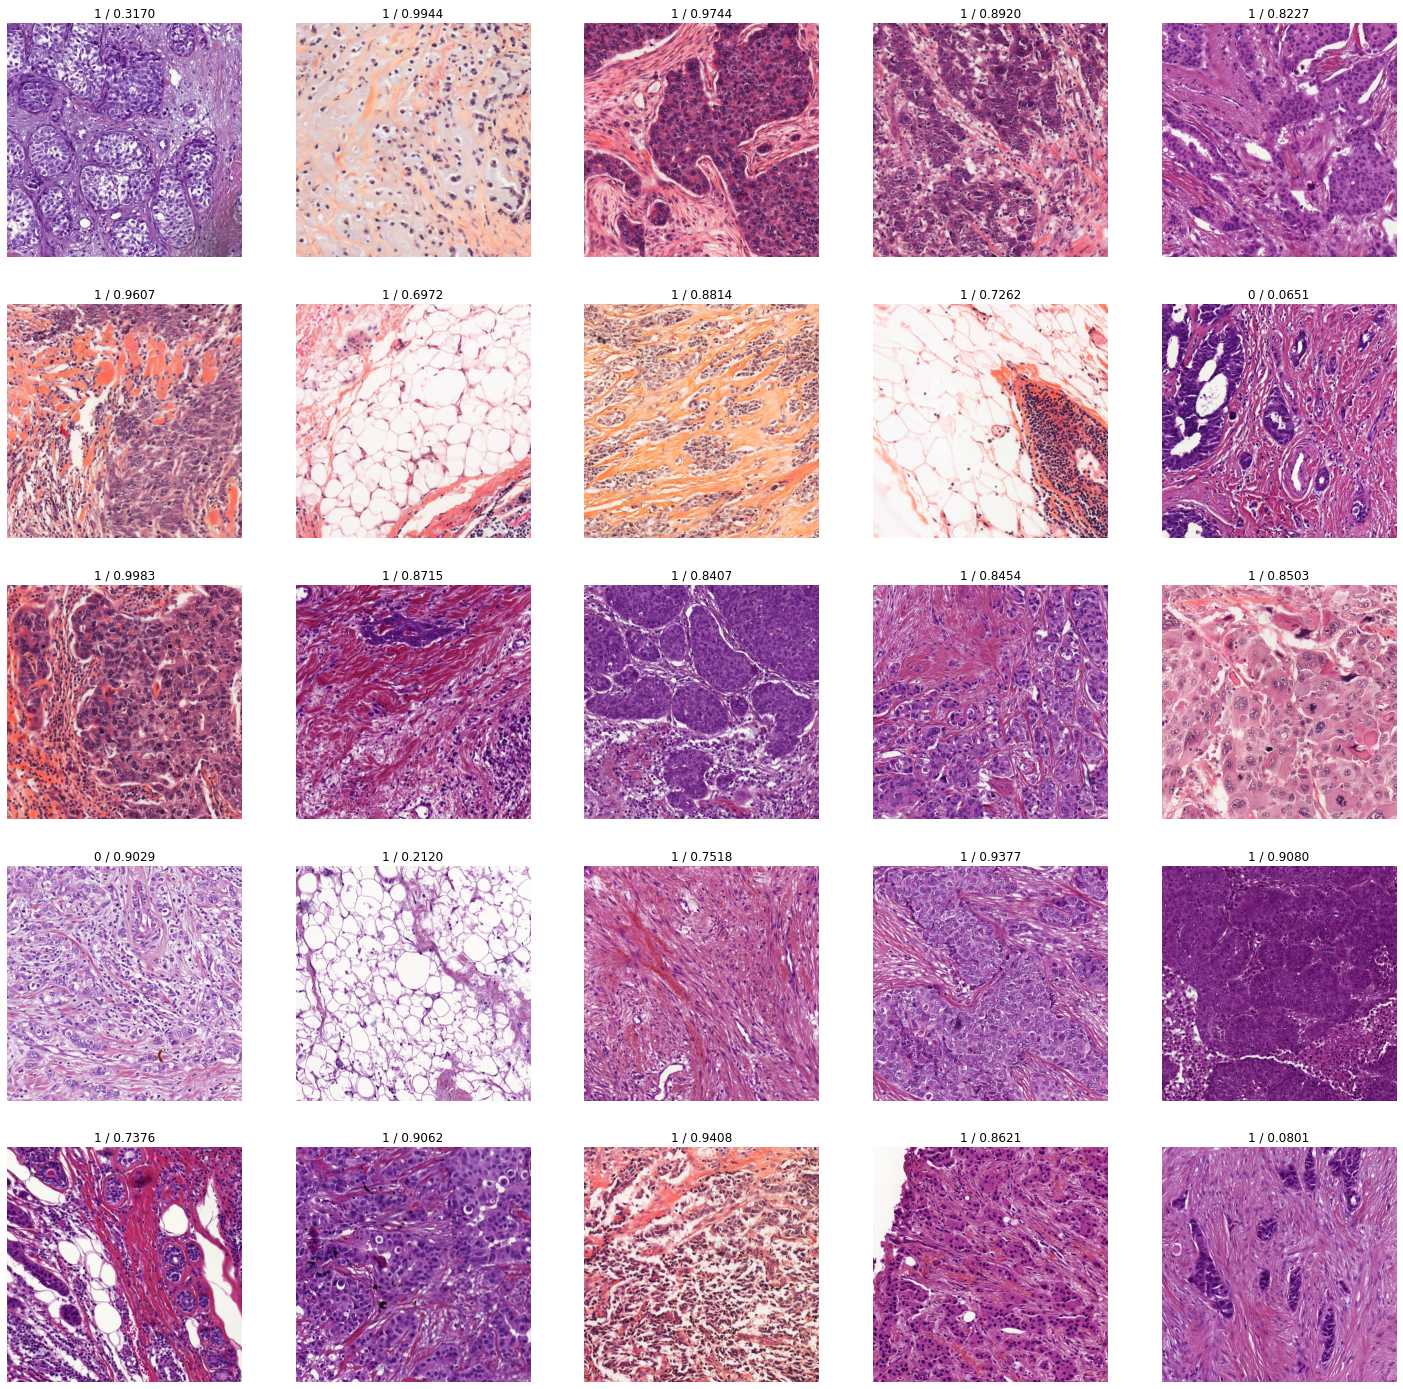

In [ ]:
k = 0
idxs = disag == k
disag_items = items[idxs]
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
for ax in axs.flatten():
    k = np.random.randint(len(disag_items))
    label = labels[idxs][k]
    pred = preds[idxs][k]
    item = disag_items[k]
    img = imread(item)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"{label.item()} / {pred.mean().item():.4f}")